In [1]:
import pandas as pd
import skimage
import numpy as np
import os

In [12]:
data = pd.read_csv('/home/jaalzate/Prostate_Cancer_TFM/Files/Bounding_Boxes/Only_Bounding.csv')

## Save Bounding Boxes to Nifti

In [39]:
import dicom2nifti
import pydicom
import SimpleITK as sitk

In [40]:
def _flatten(t):
    return [item for sublist in t for item in sublist]


def crop(image, margin, interpolator=sitk.sitkLinear):
    """
    Crops a sitk.Image while retaining correct spacing. Negative margins will lead to zero padding

    Args:
        image:  a sitk.Image
        margin: margins to crop. Single integer or float (percentage crop),
                lists of int/float or nestes lists are supported.
    """
    if isinstance(margin, (list, tuple)):
        assert len(margin) == 3, "expected margin to be of length 3"
    else:
        assert isinstance(margin, (int, float)), "expected margin to be a float value"
        margin = [margin, margin, margin]

    margin = [m if isinstance(m, (tuple, list)) else [m, m] for m in margin]
    old_size = image.GetSize()

    # calculate new origin and new image size
    if all([isinstance(m, float) for m in _flatten(margin)]):
        assert all([m >= 0 and m < 0.5 for m in _flatten(margin)]), "margins must be between 0 and 0.5"
        to_crop = [[int(sz * _m) for _m in m] for sz, m in zip(old_size, margin)]
    elif all([isinstance(m, int) for m in _flatten(margin)]):
        to_crop = margin
    else:
        raise ValueError("Wrong format of margins.")

    new_size = [sz - sum(c) for sz, c in zip(old_size, to_crop)]

    # origin has Index (0,0,0)
    # new origin has Index (to_crop[0][0], to_crop[2][0], to_crop[2][0])
    new_origin = image.TransformIndexToPhysicalPoint([c[0] for c in to_crop])

    # create reference plane to resample image
    ref_image = sitk.Image(new_size, image.GetPixelIDValue())
    ref_image.SetSpacing(image.GetSpacing())
    ref_image.SetOrigin(new_origin)
    ref_image.SetDirection(image.GetDirection())

    return sitk.Resample(image, ref_image, interpolator=interpolator)

In [41]:
path ="/nvmescratch/ceib/Prostate/Bounding_Boxes"

In [48]:
data

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality,Path_Segmentation
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/SEG_20240113_205302_952...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/SEG_20240113_205223_953...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/SEG_20240113_211223_114...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
3,5700,6173,p0052021/005700/006173/9/DICOM,p0052021/005700/006173/9/DICOM,p0052021/005700/006173/SEG_20240113_211959_757...,AXIAL DW 1500 PROSTATA,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
4,5700,6173,p0052021/005700/006173/7/DICOM,p0052021/005700/006173/7/DICOM,p0052021/005700/006173/SEG_20240113_211927_274...,AXIAL DW 1000 PROSTATA,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
...,...,...,...,...,...,...,...,...,...,...,...
530,5646,6108,p0052021/005646/006108/4/DICOM,p0052021/005646/006108/4/DICOM,p0052021/005646/006108/SEG_20240113_210039_451...,AXI PELVIS DWI B50-800,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
531,5646,6108,p0052021/005646/006108/1050/DICOM,p0052021/005646/006108/1050/DICOM,p0052021/005646/006108/SEG_20240113_205921_383...,ADC (10^-6 mm²/s):Nov 26 2019 16-59-11 CET,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,ADC,NaN
532,5646,6108,p0052021/005646/006108/1000/DICOM,p0052021/005646/006108/1000/DICOM,p0052021/005646/006108/SEG_20240113_205854_334...,DW_Synthetic: Ax FOCUS B-50-800 Synthetic B-2000,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,DWI,NaN
533,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/SEG_20240109_114231_571...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...


In [89]:
bounding_data_t2 = data[data.modality=="T2"].reset_index(drop=True)

In [91]:
bounding_data_t2

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality,Path_Segmentation
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/SEG_20240113_205302_952...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/SEG_20240113_205223_953...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/SEG_20240113_211223_114...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
3,5700,6173,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/SEG_20240113_211858_507...,AXIAL T2 ALTA RES. (de abajo arriba en próstata),/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
4,5665,6131,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/SEG_20240115_203626_074...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
...,...,...,...,...,...,...,...,...,...,...,...
292,5636,6097,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/SEG_20240113_202733_764...,T2W_TSE_TRA_IQ,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
293,5613,6070,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/SEG_20240113_203814_089...,AX T2 PROPELLER,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
294,5646,6108,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/SEG_20240113_210319_135...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...
295,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/SEG_20240109_114231_571...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...


In [90]:
os.path.dirname(os.path.join(path,'Cropped',*bounding_data_t2.image_nifti[0].split('/')[-5:]))

'/nvmescratch/ceib/Prostate/Bounding_Boxes/Cropped/005586/006040/8/NIFTI'

In [95]:
bounding_data_t2['cropped_image'] = None
bounding_data_t2['cropped_bounding_box'] = None

for i,row in bounding_data_t2.iterrows():

    bounding_imgs = os.listdir(os.path.join(path,row.bounding_box))
    bounding_imgs = [img for img in bounding_imgs if img.endswith('.dcm')]

    org_img = sitk.ReadImage(row['image_nifti'])
    img_crop = crop(org_img, margin=[0.2,0.2,0.0])

    if len(bounding_imgs) > 1:
        print('Image {} has more than one bounding box'.format(row['image_nifti']))

    for img in bounding_imgs:
        img_path = os.path.join(path,row.bounding_box,img)
        b_img = sitk.ReadImage(img_path)
        b_img_crop = crop(b_img, margin=[0.2,0.2,0.0],interpolator=sitk.sitkNearestNeighbor)
        b_img_resampled = sitk.Resample(b_img_crop, img_crop, interpolator=sitk.sitkNearestNeighbor)
        b_new_path = os.path.join(path,'Cropped',row.bounding_box,img.replace('.dcm','.nii.gz'))
        bounding_data_t2.at[i,'cropped_bounding_box'] = b_new_path
        #print('Image {} has been cropped'.format(img_path))

        os.makedirs(os.path.dirname(b_new_path), exist_ok=True)

        sitk.WriteImage(b_img_resampled, b_new_path)
    
    img_new_path = os.path.join(path,'Cropped',*row.image_nifti.split('/')[-5:])
    bounding_data_t2.at[i,'cropped_image'] = img_new_path
    os.makedirs(os.path.dirname(img_new_path), exist_ok=True)
    sitk.WriteImage(img_crop, img_new_path)

In [96]:
bounding_data_t2

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality,Path_Segmentation,cropped_image,cropped_bounding_box
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/SEG_20240113_205302_952...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/SEG_20240113_205223_953...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/SEG_20240113_211223_114...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
3,5700,6173,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/SEG_20240113_211858_507...,AXIAL T2 ALTA RES. (de abajo arriba en próstata),/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
4,5665,6131,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/SEG_20240115_203626_074...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,5636,6097,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/SEG_20240113_202733_764...,T2W_TSE_TRA_IQ,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
293,5613,6070,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/SEG_20240113_203814_089...,AX T2 PROPELLER,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
294,5646,6108,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/SEG_20240113_210319_135...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...
295,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/SEG_20240109_114231_571...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...


## Crop Prostate

In [21]:
import monai
import pandas as pd
import matplotlib.pyplot as plt

In [158]:
path ="/nvmescratch/ceib/Prostate/Bounding_Boxes"

data = pd.read_csv('/home/jaalzate/Prostate_Cancer_TFM/Files/Bounding_Boxes/Only_Bounding.csv')
data_t2 = data[data.modality=="T2"].reset_index(drop=True)
data_t2['cropped_image'] = [os.path.join(path,'Cropped',*row.image_nifti.split('/')[-5:]) for i,row in data_t2.iterrows()]
data_t2['cropped_bounding_box'] = [os.path.join(path,'Cropped',row.bounding_box,os.listdir(os.path.join(path,'Cropped',row.bounding_box))[0]) for i,row in data_t2.iterrows()]
data_t2['bounding_box'] = data_t2['bounding_box'].apply(lambda x: os.path.join(path,x,os.listdir(os.path.join(path,x))[0]))

In [159]:
loader = monai.transforms.LoadImaged(keys=["bounding_box"], image_only=False)
data_t2['Segmenter'] = [data['bounding_box_meta_dict']['0008|103e'] for data in monai.data.Dataset(data=data_t2.to_dict('records'),transform=loader)]

In [160]:
data_t2

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality,Path_Segmentation,cropped_image,cropped_bounding_box,Segmenter
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
3,5700,6173,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/6/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,AXIAL T2 ALTA RES. (de abajo arriba en próstata),/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
4,5665,6131,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/6/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,5636,6097,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/501/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,T2W_TSE_TRA_IQ,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
293,5613,6070,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/6/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,AX T2 PROPELLER,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
294,5646,6108,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/7/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
295,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG1-L


In [161]:
data_t2.Segmenter.value_counts()

Segmenter
SEG1-L            147
SEG2-L             76
SEG3-L             37
SEG1-P             13
Prueba              6
Prueba3             4
SEG1-P PRUEBA       4
Prueba_masks_2      4
SEG-1               3
4                   2
SEG2L               1
Name: count, dtype: int64

In [169]:
valid_seg = ['SEG1-L', 'SEG2-L', 'SEG3-L', 'SEG2L']
data_t2 = data_t2[data_t2.Segmenter.isin(valid_seg)].reset_index(drop=True)

In [171]:
data_t2

,subject,session,image,image_associated,bounding_box,SeriesDescription,image_nifti,bval,bvec,modality,Path_Segmentation,cropped_image,cropped_bounding_box,Segmenter
0,5586,6040,p0052021/005586/006040/8/DICOM,p0052021/005586/006040/8/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,ax T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
1,5586,6040,p0052021/005586/006040/7/DICOM,p0052021/005586/006040/7/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Ax T2 ADENOPATIAS,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
2,5596,6050,p0052021/005596/006050/13001/DICOM,p0052021/005596/006050/13001/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,AXIAL T2 TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
3,5700,6173,p0052021/005700/006173/6/DICOM,p0052021/005700/006173/6/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,AXIAL T2 ALTA RES. (de abajo arriba en próstata),/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
4,5665,6131,p0052021/005665/006131/6/DICOM,p0052021/005665/006131/6/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,5636,6097,p0052021/005636/006097/501/DICOM,p0052021/005636/006097/501/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,T2W_TSE_TRA_IQ,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
256,5613,6070,p0052021/005613/006070/6/DICOM,p0052021/005613/006070/6/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,AX T2 PROPELLER,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
257,5646,6108,p0052021/005646/006108/7/DICOM,p0052021/005646/006108/7/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,Ax T2 FSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG2-L
258,5399,5819,p0052021/005399/005819/701/DICOM,p0052021/005399/005819/701/DICOM,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,T2W_TSE,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,NaN,NaN,T2,/nvmescratch/ceib/Prostate/Bounding_Boxes/p005...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,/nvmescratch/ceib/Prostate/Bounding_Boxes/Crop...,SEG1-L


In [279]:
images = monai.transforms.LoadImaged(keys=['cropped_image','cropped_bounding_box','Path_Segmentation'],ensure_channel_first = True,image_only=False)(data_t2.iloc[0])
images = monai.transforms.CropForegroundd(keys=['cropped_image','cropped_bounding_box','Path_Segmentation'], source_key='Path_Segmentation',allow_smaller=False, margin=(0,0,1), k_divisible=(128,128,1))(images)

invalid value encountered in cast


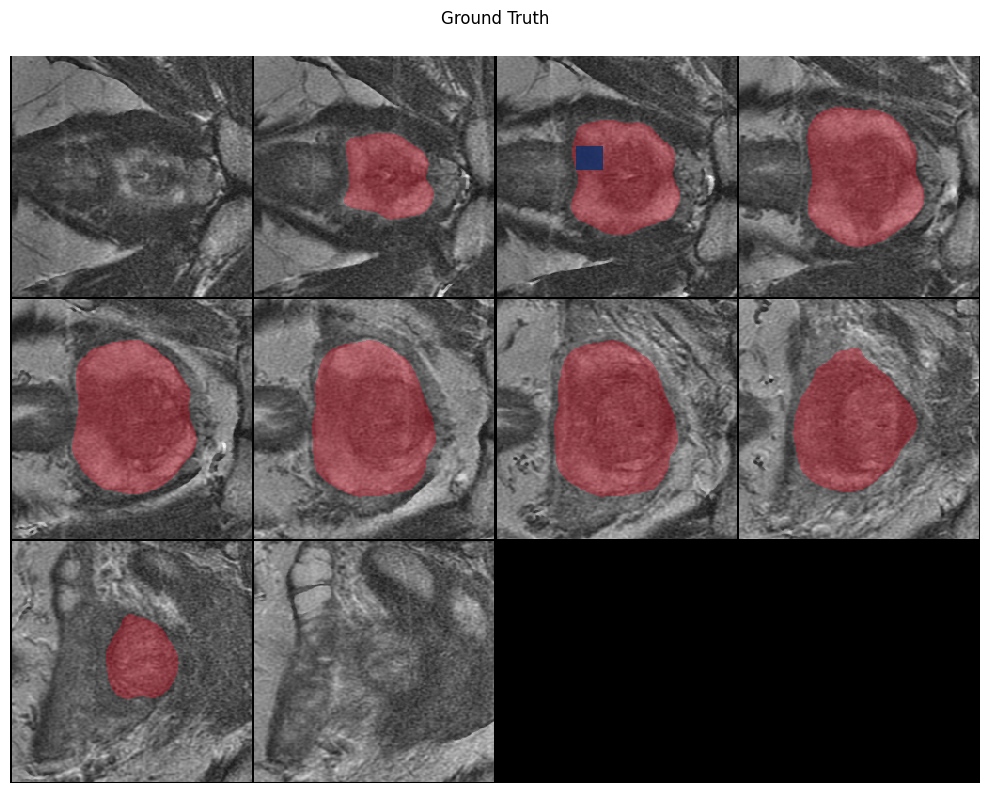

In [280]:
blended=monai.visualize.utils.blend_images(images['cropped_image'],images['Path_Segmentation'], alpha=0.3, cmap='hsv', rescale_arrays=True, transparent_background=True)
blended_2=monai.visualize.utils.blend_images(blended,images['cropped_bounding_box'], alpha=0.8, cmap='Blues', rescale_arrays=True, transparent_background=True)
monai.visualize.matshow3d(
    volume=blended_2,
    fig=None, title="Ground Truth",
    figsize=(10, 10),
    every_n=1,
    frame_dim=-1,
    show=True,
    channel_dim=0
)
plt.show()

In [282]:
images_2D = monai.transforms.SplitDimd(keys = ["cropped_image","cropped_bounding_box"],dim = -1, list_output=True, keepdim=False)(images)

In [283]:
images_2D[0]['cropped_image'].shape

torch.Size([1, 256, 256])

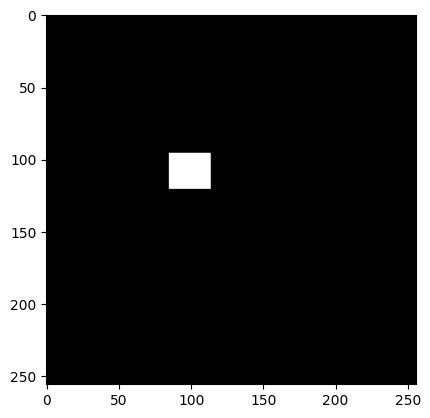

In [284]:
plt.imshow(images_2D[2]['cropped_bounding_box'][0], cmap='gray')

In [289]:
from skimage import measure

image = images_2D[2]['cropped_bounding_box'][0]

label_mask = measure.label(image, background=0)
props = measure.regionprops(label_mask)
image_height, image_width = image.shape

for prop in props:
    min_row, min_col, max_row, max_col = prop.bbox
    x_center = ((min_col + max_col)/2 ) / image_width
    y_center = (min_row + max_row) / 2 / image_height
    width = (max_col - min_col) / image_width
    height = (max_row - min_row) / image_height
    print('Label: {} Center: ({}, {}) Width: {} Height: {}'.format(prop.label, x_center, y_center, width, height))

Label: 1 Center: (0.388671875, 0.423828125) Width: 0.11328125 Height: 0.09765625


In [258]:
# Save image to jpeg

import cv2
import numpy as np

image = monai.transforms.ScaleIntensityd(keys = ["cropped_image"],maxv=255)(images_2D[6])['cropped_image'][0]

#image = images_2D[6]['cropped_image'][0]

# Nomalize image
#image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255

#save image
cv2.imwrite('image.jpeg', np.array(image))



True

In [290]:
# Save images 
save_images_path = 'Prostate_Cancer_TFM/Bounding_Boxes/Prostate_Data/images/train'
save_labels_path = 'Prostate_Cancer_TFM/Bounding_Boxes/Prostate_Data/labels/train'

for i,row in data_t2.iterrows():
    images = monai.transforms.LoadImaged(keys=['cropped_image','cropped_bounding_box','Path_Segmentation'],ensure_channel_first = True,image_only=False)(row)
    images = monai.transforms.CropForegroundd(keys=['cropped_image','cropped_bounding_box','Path_Segmentation'], source_key='Path_Segmentation',allow_smaller=False, margin=(0,0,1), k_divisible=(128,128,1))(images)

    images_2D = monai.transforms.SplitDimd(keys = ["cropped_image","cropped_bounding_box"],dim = -1, list_output=True, keepdim=False)(images)

    for j,img in enumerate(images_2D):

        label_mask = measure.label(img['cropped_bounding_box'][0], background=0)
        props = measure.regionprops(label_mask)
        image_height, image_width = img['cropped_bounding_box'][0].shape

        image_name = 'image_{}_{}.jpeg'.format(row['subject'],j)
        label_name = 'image_{}_{}.txt'.format(row['subject'],j)
        if len(props) > 0:
            with open(os.path.join(save_labels_path,label_name), 'w') as f:
                for prop in props:
                    min_row, min_col, max_row, max_col = prop.bbox
                    x_center = (min_col + max_col) / 2 / image_width
                    y_center = (min_row + max_row) / 2 / image_height
                    width = (max_col - min_col) / image_width
                    height = (max_row - min_row) / image_height
                    f.write('0 {} {} {} {}\n'.format(x_center, y_center, width, height))

        image = monai.transforms.ScaleIntensityd(keys = ["cropped_image"],maxv=255)(img)['cropped_image'][0]
        cv2.imwrite(os.path.join(save_images_path,image_name), np.array(image))
    
    # break




# Save and Crop PICAI

In [1]:
import pandas as pd

data = pd.read_csv('/home/jaalzate/Prostate_Cancer_TFM/Files/PICAI/partition_1_cv.csv')

In [2]:
data

,index,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,...,filepath_labelAI_cropped,filepath_seg_zones,filepath_seg_zones_cropped,PIRADS,cv_partition,Fold 0,Fold 1,Fold 2,Fold 3,Fold 4
0,353,10347,1000353,2020-07-15,58,9.8,0.17,58.0,SysBx+MRBx,"0+0,0+0",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,1,train,test,train,train,train
1,169,10166,1000169,2019-10-09,68,4.3,0.20,21.0,NaN,NaN,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,2,train,train,test,train,train
2,1332,11309,1001332,2012-03-04,50,7.5,0.34,22.0,MRBx,0+0,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,1,train,test,train,train,train
3,1019,11000,1001019,2019-01-11,51,1.2,0.03,33.0,NaN,NaN,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,2,train,train,test,train,train
4,176,10173,1000176,2016-11-25,64,28.0,NaN,37.0,SysBx,0+0,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,2,train,train,test,train,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1488,1350,11327,1001350,2012-06-18,49,3.0,0.10,29.0,MRBx,"0+0,0+0",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,3,train,train,train,test,train
1489,404,10398,1000404,2012-08-07,62,33.0,0.52,64.0,MRBx,3+4,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,2.0,3,train,train,train,test,train
1490,349,10343,1000349,2012-08-24,67,21.9,0.23,92.0,MRBx,"3+2,N/A",...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,4,train,train,train,train,test
1491,642,10628,1000642,2019-12-06,43,3.3,NaN,53.0,NaN,NaN,...,/nvmescratch/ceib/Prostate/input/cropped/label...,/nvmescratch/ceib/Prostate/input/labels/anatom...,/nvmescratch/ceib/Prostate/input/labels/anatom...,NaN,1,train,test,train,train,train
